# 勾配降下法Gradien descent使用(正則化なし)
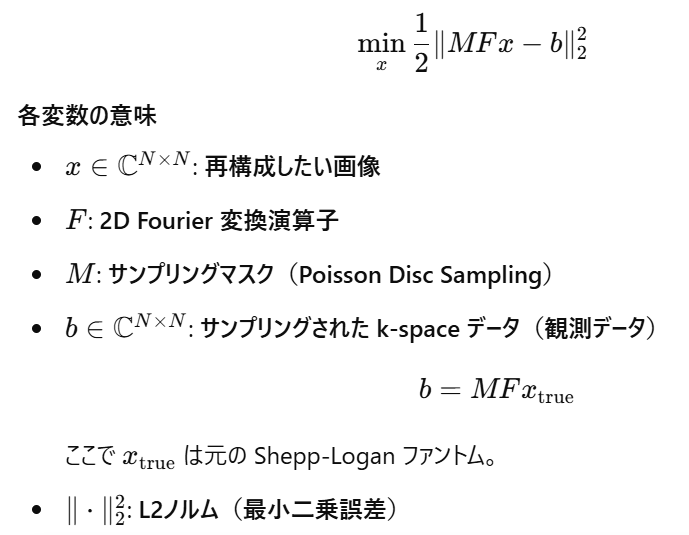

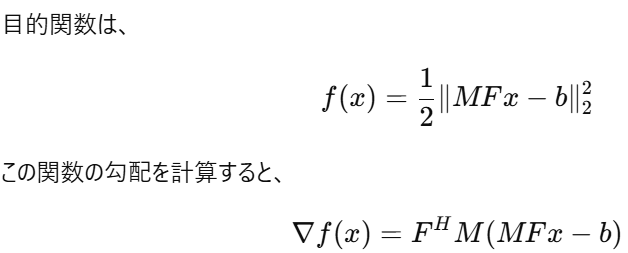

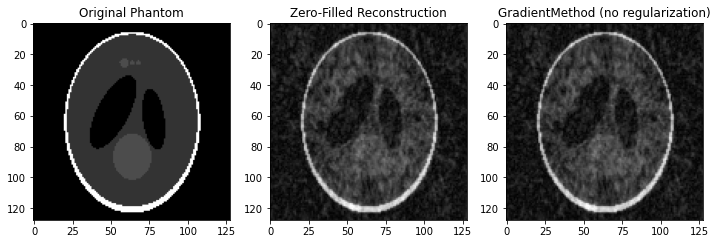

In [26]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled)

# コスト関数（GradientMethodのオプティマイズ対象）
def grad_func(x):
    """データ項 (Ax - b) の勾配を定義"""
    Ax = sp.fft(x) * mask  # k-space のサンプリング制約を適用
    return sp.ifft(Ax - kspace_sampled)  # 逆フーリエ変換で勾配を計算

# 初期値（ゼロフィルド画像）
x_init = np.copy(img_zero_filled)

# Gradient Descent による最適化
step_size = 0.5  # 学習率
max_iter = 100  # 最大イテレーション数

grad_descent = sp.alg.GradientMethod(
    gradf=grad_func, 
    x=x_init, 
    alpha=step_size, 
    max_iter=max_iter
)

# 画像再構成
while not grad_descent.done():
    grad_descent.update()

# 結果を取得
reconstructed_img = np.abs(x_init)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("GradientMethod (no regularization)")
plt.show()


# 勾配降下法Gradien descent使用(TV正則化)

proxg=Noneにすれば勾配降下法gradient descentになる(ただしTVの正則化項も無視される)

proxg=proxgにすると、近接勾配法になる。

そうした上で、accelerate=True　とするとFISTAになる


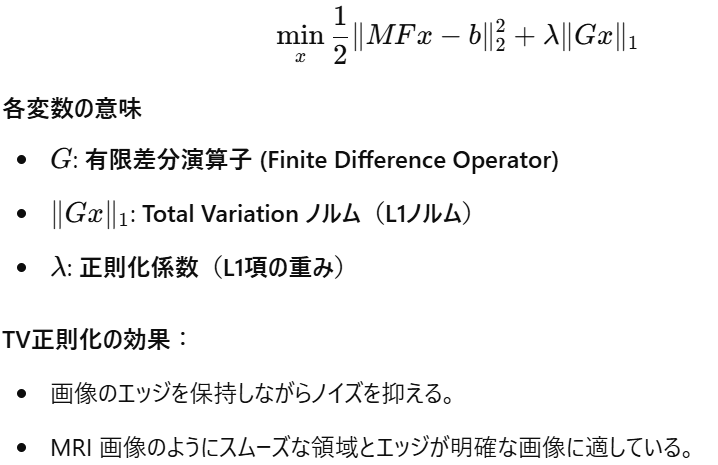

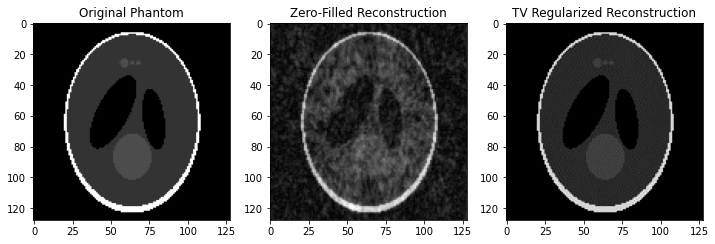

In [24]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled)

# TV正則化の係数
lambda_tv = 0.01  # TV正則化の強さ

# 線形オペレータ（Fourier変換 + サンプリング）
F = sp.linop.FFT(phantom.shape)  # Fourier変換演算子
M = sp.linop.Multiply(phantom.shape, mask)  # マスク適用演算子
A = M * F  # 正しく演算を組み合わせる

# TV正則化オペレータ
G = sp.linop.FiniteDifference(A.ishape, axes=[0, 1])  # x, y の差分を取る
proxg = sp.prox.L1Reg(A.ishape, lambda_tv)  # 画像の形状に合わせる

# コスト関数の勾配（データフィデリティ項）
def grad_func(x):
    Ax = sp.fft(x) * mask  # k-space のサンプリング制約を適用
    return sp.ifft(Ax - kspace_sampled)  # 逆Fourierで勾配を計算

# 初期値（ゼロフィルド画像）
x_init = np.copy(img_zero_filled)

# Gradient Descent による最適化 (TV 正則化付き)
step_size = 0.5  # 学習率
max_iter = 100  # 最大イテレーション数

grad_descent = sp.alg.GradientMethod(
    gradf=grad_func,
    x=x_init,
    alpha=step_size,
    proxg=proxg,  # TV 正則化のプロキシマル演算を適用
    max_iter=max_iter,
    accelerate=True  # True : Nesterov Acceleration を適用(APGD/FISTA),  False : PGD/ISTA
)

# 画像再構成
while not grad_descent.done():
    grad_descent.update()

# 結果を取得
reconstructed_img = np.abs(x_init)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("TV Regularized Reconstruction")
plt.show()
